# Submission for Regression with an Abalone Dataset (TOP 21% of public leaderboard)

The goal of this competition is to predict the **number of Rings** (an indicator of age) of abalone from various physical measurements. Since the number of rings of abalone is a continuous numerical variable, this is a regression problem. The evaluation metric is the **Root Mean Squared Logarithmic Error**.

Based on preliminary tests, it was determined that a **CatBoostRegressor** is the best model for this task.

## Sections
1. Import Libraries and Data
2. Preprocessing
3. Validations
4. Predictions
5. Visualisation of predictions

#### 1. Import Libraries and Data

In [1]:
# Data exploration and manipulation
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from catboost import CatBoostRegressor

# Validation
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_log_error 

# manipulate dates, e.g., get today's date
from datetime import date

In [2]:
# for the final predictions i am using the full dataset
train_raw = pd.read_csv('data/playground-series-s4e4/train.csv', index_col="id")
test_raw = pd.read_csv('data/playground-series-s4e4/test.csv', index_col="id")

In [3]:
train_raw.tail(3)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6
90614,I,0.425,0.325,0.100,0.3455,0.1525,0.0785,0.1050,8


In [4]:
test_raw.head(3)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405


#### 2. Preprocessing
 - Convert Sex column from categorical to numerical
 - Create a "Dimention Cluster" column: this was found to imporve the score 

In [5]:
# concatenate train and test so we can do the preprocessing to both simultaneously
full_df = pd.concat([train_raw,test_raw], ignore_index=False)

# encode sex as new binary columns
full_df = pd.get_dummies(full_df,drop_first=True, dtype=int)

#Create a cluster feature
kmeans = KMeans(n_clusters=3, random_state=1111)
full_df["DimensionsCluster"] = kmeans.fit_predict(full_df[["Whole weight", "Length"]])

# reorder columns
full_df = full_df[['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Sex_I', 'Sex_M',
       'DimensionsCluster','Rings']]

# recover the processed train sets
train_mod = full_df[full_df.index.isin(train_raw.index)] #_mod stands for modifies
test_mod = full_df[full_df.index.isin(test_raw.index)].dropna(axis = 1)

In [6]:
# Prepare feature and taget sets
X = train_mod.iloc[:,:-1]  # features set
y = train_mod.iloc[:,-1]  # target set

#### 3. KFold Cross-Validation

Calculate the RMSLE of 3 different splits of the data to get an idea of the model effectiveness in calculating the age of abalone

In [7]:
# Instantiate the Catboost Regressor
cbr = CatBoostRegressor(iterations = 5000, depth = 7, verbose = False, random_state=1111)

# KFold Splits
kf = KFold(n_splits = 3, shuffle = True, random_state = 1111)
splits = kf.split(X)

#empty list where to store the errors
errors = []

# Access the training and validation indices of splits
for train_index, val_index in splits:
    
    # Setup the training and validation data
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    
    # By default, the catboostregressor uses RMSE objective function, since i want to optimize for RMSLE I will log the target and anti-log the predictions
    # log the target
    y_log = np.log(y_train) 
    
    # Fit the model
    cbr.fit(X_train, y_log)
    # Make predictions
    predictions = cbr.predict(X_val)
    
    #antilog predictions
    pred_exp = np.exp(predictions)
    
    errors.append(root_mean_squared_log_error(y_val, pred_exp))
    
    # Print the RMSLE
    print("Split RMSLE: " + str(root_mean_squared_log_error(y_val, pred_exp)))
    
print("Mean RMSLE:", sum(errors) / len(errors))

Split RMSLE: 0.1491318031481951
Split RMSLE: 0.14944795340655
Split RMSLE: 0.14805443121016365
Mean RMSLE: 0.1488780625883029


# 4. Make Predictions on Full Data

In [8]:
# Create a CatBoostRegresssor object
cbr = CatBoostRegressor(iterations = 5000, depth = 7, verbose = False, random_state=1111)


# By default, the catboostregressor uses RMSE objective function, since i want to optimize for RMSLE I will log the target and anti-log the predictions
# log the target
y_log = np.log(y)

# Fit the model
cbr.fit(X, y_log)

# make predictions
final_predictions = cbr.predict(test_mod)

#antilog predictions
final_predictions = np.exp(final_predictions)

Convert array to a dataframe for easier export and visualisations

In [9]:
submission_df = pd.DataFrame(final_predictions, columns = ["Rings"], index = test_mod.index)
submission_df.head()

,Rings
id,
90615,9.827939
90616,9.667183
90617,9.947188
90618,10.077826
90619,7.526914


Export Predictions - The kaggle score achieved was 0.14671, which, at the time of submission, landed number 422 out of 2,006 (21%) of the public leaderboard

In [10]:
# get todays date
today = date.today() 

# create the file name with todays date (this prevents us from overwriting previous files
file_path = "data/submission_" + str(today) + ".csv"

# output submission csv file (this should be uploaded to Kaggle without any modification
submission_df.to_csv(file_path)

## What do the predictions look like compared to the training data?

### Plot 1 - Target vs Features

Prepare Dataset for Visualizations

In [11]:
# add the predicitons to the test set
predictions_full = test_mod.merge(submission_df, left_index = True, right_index = True)
# round predictions (makes the visualisations clearer)
predictions_full['Rings'] = round(predictions_full['Rings'],0).astype(int)

Plots

In [19]:
predictions_full['Rings'].max()

22

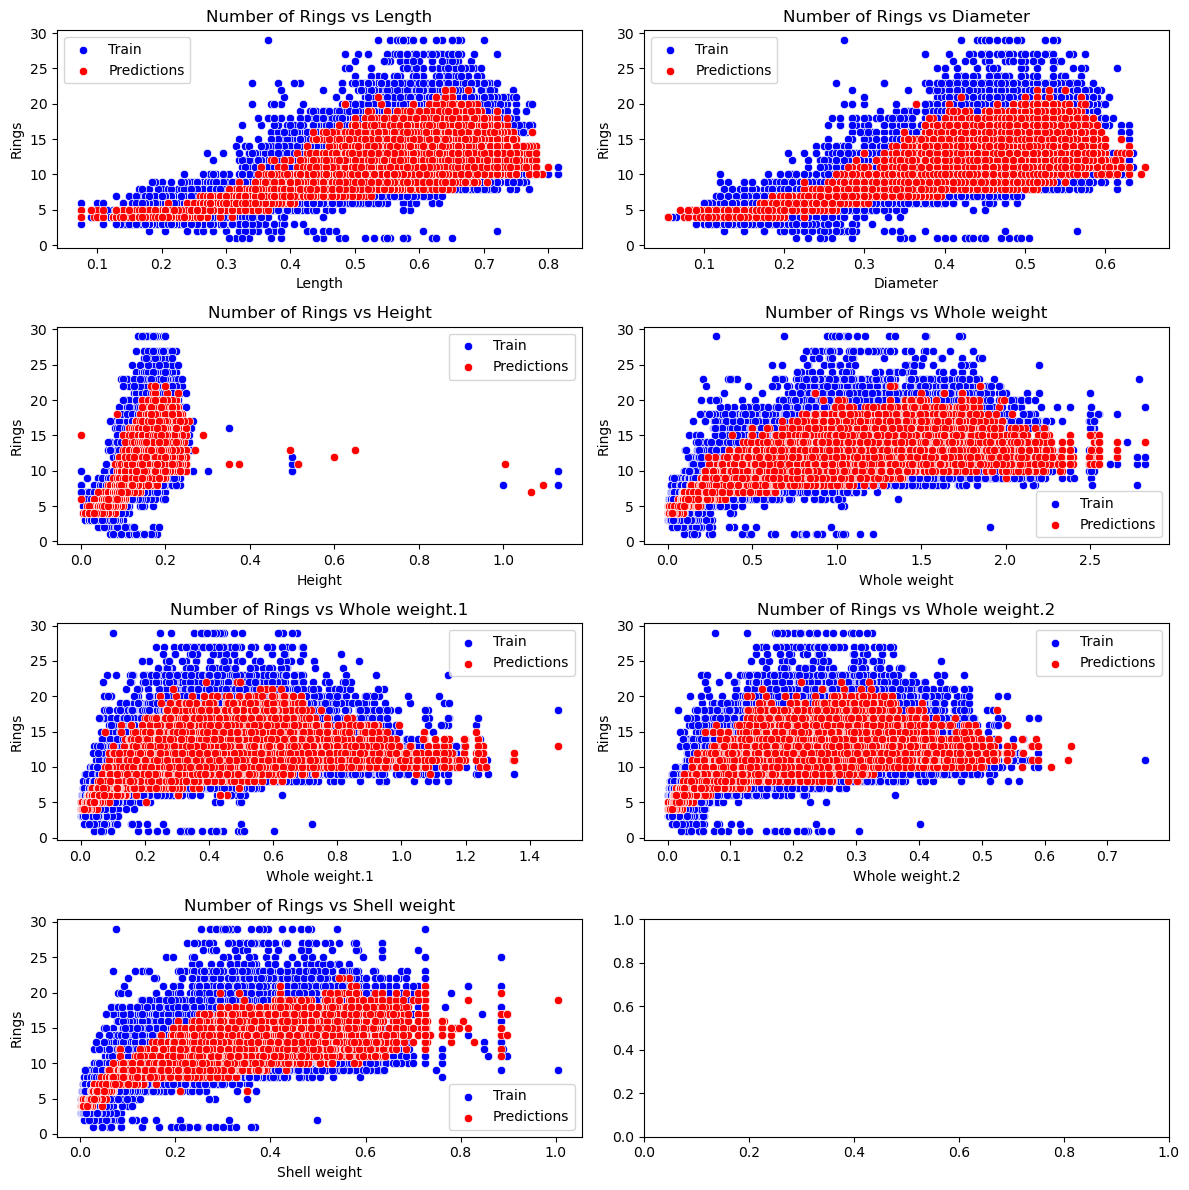

In [16]:
# Select feature to plot against the target
features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1','Whole weight.2', 'Shell weight']

# Create a new figure with a 2x2 grid layout
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# Iterate over each feature and subplot position
for i, feature in enumerate(features):
    
    # Determine the position of the subplot in the grid
    row = i // 2
    col = i % 2
    
    # Plot Rings vs the various features in the train set in blue
    sns.scatterplot(x=feature, y='Rings', data=train_mod, color='blue', label='Train', ax=axs[row, col])

    # Plot the predicted Rings vs the various features in red
    sns.scatterplot(x=feature, y='Rings', data=predictions_full, color='red', label="Predictions", ax=axs[row, col])

    # Add title and labels
    axs[row, col].set_title(f'Number of Rings vs {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Rings')
    axs[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('data/final_predictions.png')

### Plot 2 - Average feature vs predicted targets

In [13]:
# Calcualte the average feature values for each number of Rings
train_grouped = train_mod.groupby('Rings', as_index = False).mean(numeric_only = True)
predictions_grouped = predictions_full.groupby('Rings', as_index = False).mean(numeric_only = True)

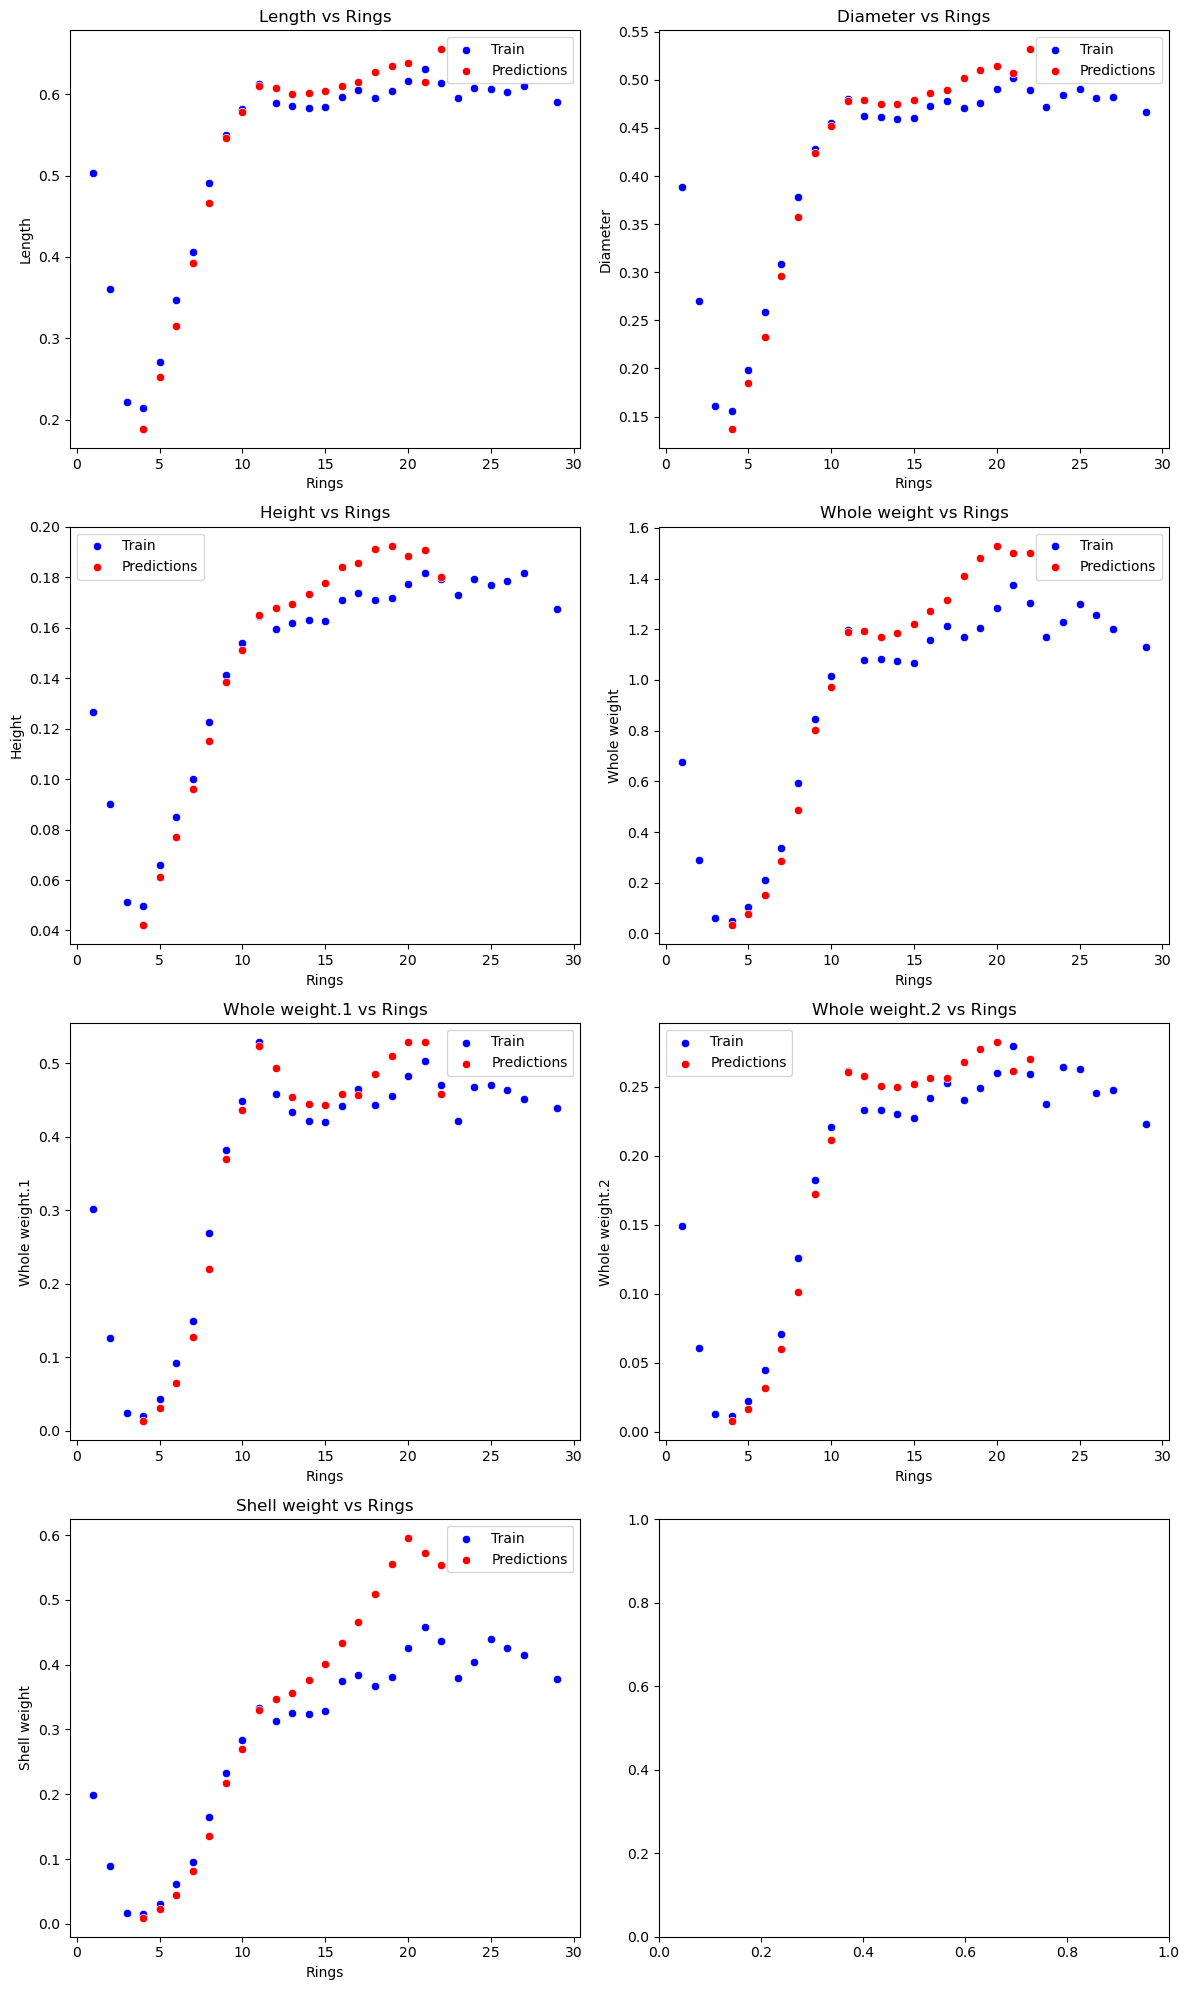

In [14]:
# Select feature to plot against the target
features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1','Whole weight.2', 'Shell weight']

# Create a new figure with a 2x2 grid layout
fig, axs = plt.subplots(4, 2, figsize=(12, 20))

# Iterate over each feature and subplot position
for i, feature in enumerate(features):
    
    # Determine the position of the subplot in the grid
    row = i // 2
    col = i % 2
    
    # Plot the average features values vs Rings in the train set in blue
    sns.scatterplot(y=feature, x='Rings', data=train_grouped, color='blue', label='Train', ax=axs[row, col])

    # Plot the average feature value vs predicted Rings in red
    sns.scatterplot(y=feature, x='Rings', data=predictions_grouped, color='red', label="Predictions", ax=axs[row, col])

    # Add title and labels
    axs[row, col].set_title(f'{feature} vs Rings')
    axs[row, col].set_ylabel(feature)
    axs[row, col].set_xlabel('Rings')
    axs[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()